In [1]:
import pandas as pd
import re
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from nltk import FreqDist


In [2]:
list=["biology","cooking","crypto","diy","robotics","travel"]

Make a new dataframe called training_set consisting of the training set data.

In [3]:
training_list=[]
for x in list:
    path = 'stackexchange/{}.csv'.format(str(x))
    training_list.append(pd.read_csv(path,usecols=['title','content','tags'],index_col=0))
training_set = pd.concat(training_list, axis=0 , join='outer')
training_set.dropna()
training_set= training_set.reset_index()
training_set.head(10)
training_set = training_set.replace(re.compile('<.*?>'), ' ')
training_set = training_set.replace(re.compile('\n'), ' ')
#for y in list:
    #path = 'stackexchange/{}.csv'.format(str(y))
    #str(list[x])=pd.read_csv(path,usecols=['title','content','tags'],index_col=0)

In [4]:
training_set.shape

(87000, 3)

In [5]:
training_set['content'] = training_set['content'].map(lambda x: x.lstrip('<p>').strip('<p').rstrip('<p>'))

In [8]:
print(training_set['tags'].values)

['ribosome binding-sites translation synthetic-biology' 'rna biochemistry'
 'immunology cell-biology hematology' ...,
 'customs-and-immigration officials registration macedonia' 'visas austria'
 'untagged']


In [9]:
test = zip(np.array(training_set['title'].values),np.array(training_set['content'].values),np.array(training_set['tags'].values))

In [10]:
subset = training_set[['title','content','tags']]
tuples = [tuple(x) for x in subset.values]

In [11]:
tuples[0][2]

'ribosome binding-sites translation synthetic-biology'

In [12]:
print(len(tuples))

87000


In [13]:
tuples[2][:]

('Are lymphocyte sizes clustered in two groups?',
 ' Tortora writes in  Principles of Anatomy and Physiology :        Lymphocytes may be as small as 6–9 μm in diameter or as large as 10–14 μm in diameter.      Those ranges are quite close to each others. Should the above be taken to mean that lymphocytes sizes are clustered in two groups, or is it just a way of saying that lymphocytes are 6-14 μm?  ',
 'immunology cell-biology hematology')

Get some tags 

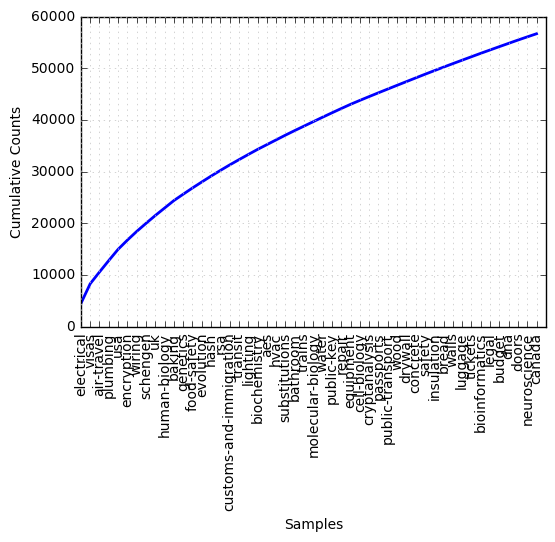

In [14]:
tags=[]
for tag in training_set['tags']:
    for t in tag.split():
        tags.append(t)
fdist1 = FreqDist(tags)
#fdist1.most_common(50)
fdist1.plot(50, cumulative=True)